In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#reading CSV tables
admissions = pd.read_csv("./data/ADMISSIONS.csv")
patients = pd.read_csv("./data/PATIENTS.csv")
services = pd.read_csv("./data/SERVICES.csv")
icustays = pd.read_csv("./data/ICUSTAYS.csv")
drgcodes = pd.read_csv("./data/DRGCODES.csv")
prescriptions = pd.read_csv("./data/PRESCRIPTIONS.csv")

In [3]:
# cos mi tu nie pasowało bo w df mamy 402 wiersze a jest 129 przyjec

In [4]:
# Dokonamy imputacji zmiennych kategorycznych
admissions['language'] = admissions['language'].fillna('Missing_language')
admissions['religion'] = admissions['religion'].fillna('Missing_religion') 
admissions['marital_status'] = admissions['marital_status'].fillna('Missing_marital_status') 

In [5]:
# Dokonamy imputacji zmiennych ciągłych
drgcodes.drg_severity.fillna(drgcodes.drg_severity.median(), inplace=True)
drgcodes.drg_mortality.fillna(drgcodes.drg_mortality.median(), inplace=True)

### Wybieramy interesujące nasz kolumny

In [6]:
admissions_opt = admissions[['subject_id', 'hadm_id', 'admission_type' ,
                             "insurance", "language", "religion",
                             "marital_status", "ethnicity"]]
patients_opt = patients[['subject_id', "gender"]]
services_opt = services[['row_id', 'subject_id', 'hadm_id', 'prev_service', 'curr_service']]
icustays_opt = icustays[['subject_id', 'hadm_id', 'los']].groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
drgcodes_opt = drgcodes.drop(['description', 'row_id', 'drg_code'], axis = 1) # drg_code ma 160 unikatowych wart. na 297 max
prescriptions_opt = prescriptions[['subject_id', 'hadm_id', 'drug_type']]

### Kodujemy i grupujemy zmienne będące w wybranych przez nas tabelach

In [7]:
from sklearn.preprocessing import OneHotEncoder

def encode_and_join(encode, df):
    enc = OneHotEncoder(handle_unknown='ignore')
    
    enc_df = pd.DataFrame(
        enc.fit_transform(df[encode]).toarray(),
        columns = enc.get_feature_names(input_features = encode)
    )

    return df.join(enc_df).drop(encode, axis = 1)

- services

In [8]:
encode = ['prev_service', 'curr_service']
services_opt = encode_and_join(encode, services_opt)

services_opt = services_opt.groupby(by = ['subject_id','hadm_id']).sum().reset_index().drop('row_id', axis = 1)
services_opt.shape

(129, 24)

- icustays

In [9]:
icustays_opt = icustays_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
icustays_opt.shape

(129, 3)

- drgcodes

In [10]:
encode = ['drg_type'] # 'drg_code'
# 'drg_severity', 'drg_mortality' - tych chyba nie ma co przekodowywać z OHE
drgcodes_opt = encode_and_join(encode, drgcodes_opt)

drgcodes_opt = drgcodes_opt.groupby(
    by = ['subject_id', 'hadm_id'])[['drg_severity', 'drg_mortality']].mean().join(
    drgcodes_opt.groupby(by = ['subject_id', 'hadm_id']).sum().drop(['drg_severity', 'drg_mortality'], axis = 1)
).reset_index()
drgcodes_opt.shape

(129, 7)

- prescriptions

In [11]:
encode = ['drug_type']
prescriptions_opt = encode_and_join(encode, prescriptions_opt)

prescriptions_opt = prescriptions_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
prescriptions_opt.shape # nie kazdy pacjent otrzymal recepte

(122, 5)

### Łączymy wszystkie tabele

In [12]:
df2 = admissions_opt.join(patients_opt.set_index("subject_id"), on = "subject_id")
df2 = df2.join(services_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(icustays_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(drgcodes_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(prescriptions_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])

In [13]:
# przypisujemy każdej wzycie 0 przypisanych recept skoro nie zostaly one zanotowane
df2.drug_type_ADDITIVE.fillna(0, inplace=True)
df2.drug_type_BASE.fillna(0, inplace=True)
df2.drug_type_MAIN.fillna(0, inplace=True)

In [14]:
# chyba lepiej przewidywać na podstawie tych 129 przyjęć, bo nie wiem co te 402 wiersze oznaczały dokładnie

In [15]:
#tables joins to data frame
df = admissions.join(patients.set_index("subject_id"), on = "subject_id", lsuffix="_adm", rsuffix="_pat")
df = df.join(services.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df = df.join(icustays.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"], rsuffix="_icu")
df = df.join(drgcodes.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"], rsuffix="_drg")

Kilka luźnych uwag do zanotowania:
- część zmiennych tworzy wiele rekordów do pojedynczego pobytu pacjenta (np. curr_service, te od kodów DRG), a df musi mieć formę: wiersz opisujący pobyt pacjenta - target 
- trzeba te zmienne zagregować albo z nich zrezygnować
- z tych powodów nie wziąłem np microbiology events
- zmiennych jest 15 więc spokojnie może coś odpaść przy EDA
- CSVki w folderze jak wyżej umieście i nie wrzucamy go na repo, jak będziemy mieli docelowy df to wtedy trzeba zapisać do CSV i na repo
- jak jakieś inne zmienne itp. to kodu wiele nie ma wiadomo co i gdzie możecie zmieniać

In [17]:
df = df[[
    #identyfikator pobytu pacjenta: subject_id + hadm_id
    "subject_id", "hadm_id",
    ###ADMISSIONS
    #czas przyjęcia, wypisu
    "admittime", "dischtime",
    #typ pobytu
    "admission_type",
    #dane personalne
    "insurance", "language", "religion", "marital_status", "ethnicity",
    #TARGET zmienna binarna śmierć w szpitalu
    "hospital_expire_flag",
    ###PATIENTS
    "gender", 
    #data urodzenia
    "dob",
    ###SERVICES
    #opieka/zabieg
    "curr_service",
    ###ICUSTAYS
    #długość pobytu na ICU
    "los",
    ###DRGCODES
    #para identyfikująca 
    "drg_type", "drg_code",
    "drg_severity", "drg_mortality"
]]

In [18]:
df

,subject_id,hadm_id,admittime,dischtime,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,dob,curr_service,los,drg_type,drg_code,drg_severity,drg_mortality
0,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,2094-03-05 00:00:00,MED,1.6325,HCFA,416,4.0,3.0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,Private,Missing_language,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,2090-06-05 00:00:00,MED,13.8507,HCFA,205,4.0,3.0
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,Missing_marital_status,UNKNOWN/NOT SPECIFIED,1,F,2038-09-03 00:00:00,MED,2.6499,HCFA,416,4.0,3.0
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,APR,3153,3.0,3.0
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,HCFA,491,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,APR,2013,3.0,3.0
127,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,MS,308,4.0,3.0
128,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0
128,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0


Zmienna celu to: hospital_expire_flag

W kolumnach language, religion, marital_status, drg_severity i drg_mortality mamy braki danych

In [19]:
from datetime import datetime

# to chyba jest już nie potrzebne 
# kolumna LOS trzyma długość pobytu w dniach

df['admittime'] =  pd.to_datetime(df['admittime'], format='%Y-%m-%d %H:%M:%S')
df['dischtime'] =  pd.to_datetime(df['dischtime'], format='%Y-%m-%d %H:%M:%S')
length = df["dischtime"] - df["admittime"]
length.rename("my_name")
df['length'] = length.dt.total_seconds()
df = df.drop(['admittime', 'dischtime'], axis=1)
df

,subject_id,hadm_id,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,dob,curr_service,los,drg_type,drg_code,drg_severity,drg_mortality,length
0,10006,142345,EMERGENCY,Medicare,Missing_language,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,2094-03-05 00:00:00,MED,1.6325,HCFA,416,4.0,3.0,763560.0
1,10011,105331,EMERGENCY,Private,Missing_language,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,2090-06-05 00:00:00,MED,13.8507,HCFA,205,4.0,3.0,1196820.0
2,10013,165520,EMERGENCY,Medicare,Missing_language,CATHOLIC,Missing_marital_status,UNKNOWN/NOT SPECIFIED,1,F,2038-09-03 00:00:00,MED,2.6499,HCFA,416,4.0,3.0,229020.0
3,10017,199207,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,APR,3153,3.0,3.0,696180.0
3,10017,199207,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,HCFA,491,4.0,3.0,696180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,APR,2013,3.0,3.0,108300.0
127,44222,192189,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,MS,308,4.0,3.0,108300.0
128,44228,103379,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0,830760.0
128,44228,103379,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0,830760.0


In [20]:
df = df.drop(['dob'], axis=1)

In [21]:
# Dokonamy imputacji zmiennych kategorycznych
df['language'] = df['language'].fillna('Missing_language')
df['religion'] = df['religion'].fillna('Missing_religion') 
df['marital_status'] = df['marital_status'].fillna('Missing_marital_status') 

In [22]:
# Dokonamy imputacji zmiennych ciągłych
df.drg_severity.fillna(df.drg_severity.median(), inplace=True)
df.drg_mortality.fillna(df.drg_mortality.median(), inplace=True)

In [23]:
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

columns_to_encode = ['admission_type', 'insurance', 'curr_service', 'drg_type', 'ethnicity', 'gender', 'language', 'religion', 'marital_status', 'drg_severity', 'drg_mortality']

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(
    enc.fit_transform(df[columns_to_encode]).toarray(),
    columns = enc.get_feature_names(input_features = columns_to_encode)
)

enc_df = df.join(enc_df).drop(columns_to_encode, axis = 1)


In [24]:
enc_df

,subject_id,hadm_id,hospital_expire_flag,los,drg_code,length,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,curr_service_CMED,curr_service_CSURG,curr_service_GU,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,curr_service_TSURG,curr_service_VSURG,drg_type_APR,drg_type_HCFA,drg_type_MS,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,gender_F,gender_M,language_ENGL,language_MAND,language_Missing_language,language_POLI,language_RUSS,language_SPAN,religion_BUDDHIST,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_JEWISH,religion_MUSLIM,religion_Missing_religion,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_Missing_marital_status,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,drg_severity_2.0,drg_severity_3.0,drg_severity_4.0,drg_mortality_1.0,drg_mortality_2.0,drg_mortality_3.0,drg_mortality_4.0
0,10006,142345,0,1.6325,416,763560.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,10011,105331,1,13.8507,205,1196820.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,10013,165520,1,2.6499,416,229020.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10017,199207,0,2.1436,3153,696180.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10017,199207,0,2.1436,491,696180.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,0,1.3279,2013,108300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
127,44222,192189,0,1.3279,308,108300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
128,44228,103379,0,4.6191,7203,830760.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0

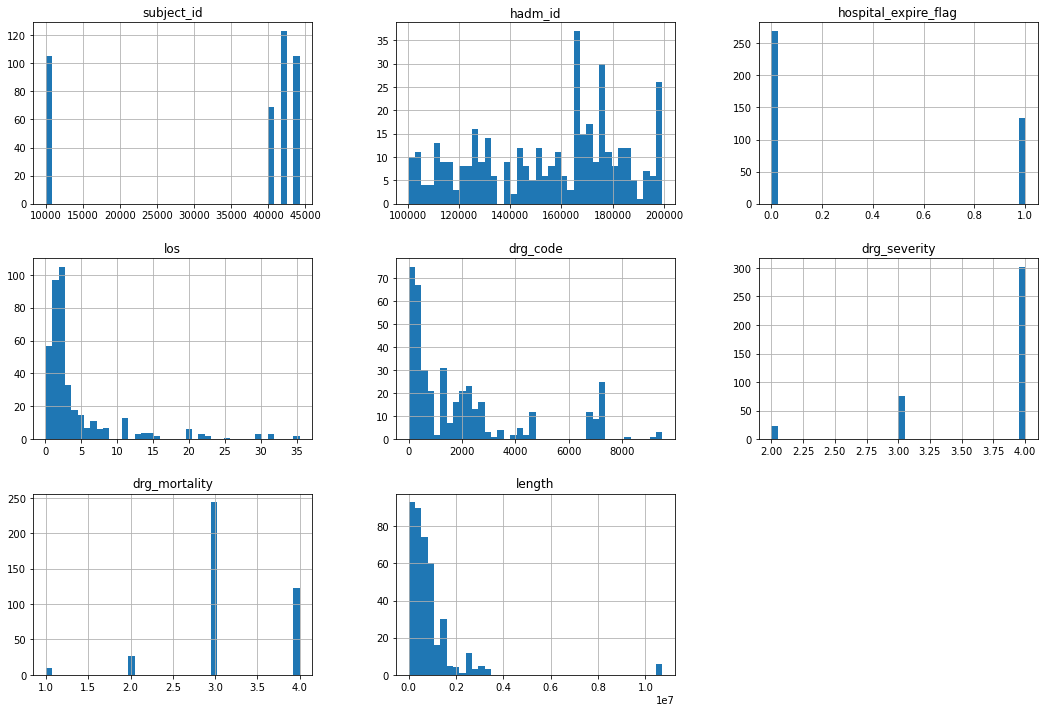

In [25]:
df.hist(bins = 40, figsize=(18, 12))

plt.show()

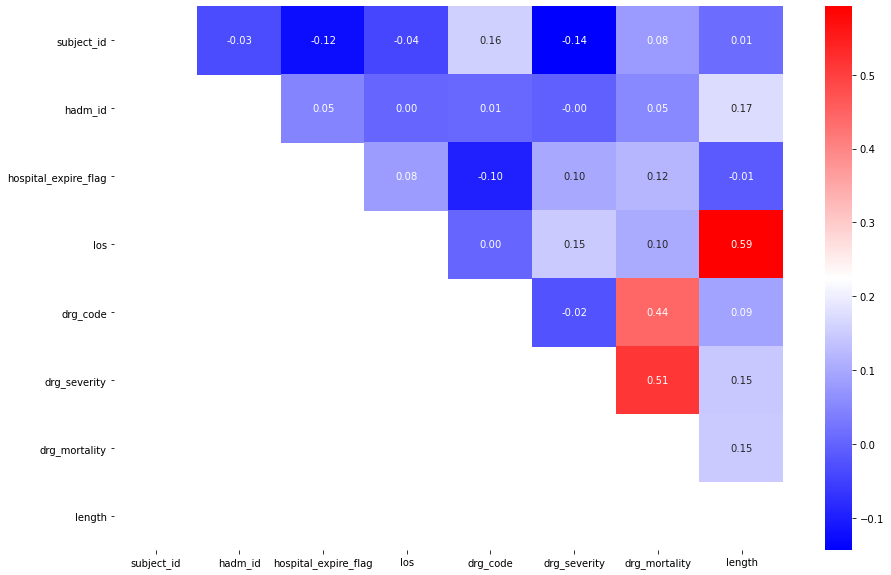

In [26]:
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool)).transpose()

plt.subplots(figsize=(15,10))
sns.heatmap(df_corr, mask = mask, cmap = 'bwr', annot=True, fmt='.2f')
plt.show()

* drg_severity jest dodatnio skorelowany z drg_mortality

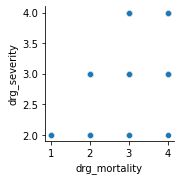

In [27]:
# Zobaczymy odkryte zależności na wykresach punktowych

sns.pairplot(df, y_vars="drg_severity", x_vars="drg_mortality")
plt.show()

Korelacji nie za bardzo widać na rysunku

### Modele

In [28]:
y = np.array(enc_df['hospital_expire_flag'])
X = enc_df.drop(['hospital_expire_flag'],axis=1)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
X.head()

,subject_id,hadm_id,los,drg_code,length,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,curr_service_CMED,curr_service_CSURG,curr_service_GU,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,curr_service_TSURG,curr_service_VSURG,drg_type_APR,drg_type_HCFA,drg_type_MS,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,gender_F,gender_M,language_ENGL,language_MAND,language_Missing_language,language_POLI,language_RUSS,language_SPAN,religion_BUDDHIST,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_JEWISH,religion_MUSLIM,religion_Missing_religion,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_Missing_marital_status,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,drg_severity_2.0,drg_severity_3.0,drg_severity_4.0,drg_mortality_1.0,drg_mortality_2.0,drg_mortality_3.0,drg_mortality_4.0
0,10006,142345,1.6325,416,763560.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,10011,105331,13.8507,205,1196820.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,10013,165520,2.6499,416,229020.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10017,199207,2.1436,3153,696180.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10017,199207,2.1436,491,696180.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Dummy Classifier

In [31]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='prior', random_state=42)
dc.fit(X_train,y_train)
y_hat = dc.predict(X_test)
print('\ny:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))


y:     [1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0]
y_hat: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
# Całkiem dobrze działa :) 

### Regresja logistyczna

In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train,y_train)
y_hat = lr.predict(X_test)
print('y:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))

y:     [1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0]
y_hat: [0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
